# Portfolio Optimization using Quantum Algorithms (VQE and QAOA)

Currently, quantum computing hardware is limited by the number of qubits, connectivity, and a number of other factors. However, even with the current limitations, many problems can be solved with the small-scale hardware, by simulation, or by a combination of classical and quantum techniques. Among these techniques are two extremely promising algorithms, the Variational Quantum Eigensolver (VQE) and the Quantum Approximate Optimization Algorithm (QAOA) respectively.

The VQE is derived from a technique in quantum mechanics – the [Variational Method](https://en.wikipedia.org/wiki/Variational_method_(quantum_mechanics)) – and is a way of approximating the lowest energy as well as its corresponding eigenstate for a system's Hamiltonian. However, this technique is not limited to just physics or quantum chemistry. 

These techniques can be applied to problems in other domains, like Finance, if the problem can be cast in ways that are amenable to the logic of quantum computers.

To this end, the goal of this notebook is to
1. Solve a portfolio optimization problem using quantum algorithms.
2. Compare the Variational Quantum Eigensolver (VQE) to the Quantum Approximate Optimization Algorithm (QAOA).

## The Portfolio Optimization Formulation

Before getting into the details of the VQE algorithm and QAOA respectively, the portfolio optimization problem will need to be defined. 

The form of this problem is adapted from [Improving Variational Quantum Optimization using CVaR (Barkoutsos et al. 2019).](https://arxiv.org/abs/1907.04769), where for $n$ assets that can be chosen from:
$$
\begin{aligned}
\max_{x \in \{0, 1\}^n} \left( \mu^T x - q x^T \sigma x \right)  \\
\text{subject to: } 1^T x = B .
\end{aligned}
$$

In this optimization problem:
- $x \in \{0, 1\}^n$ is the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ is the vector of means for the daily percent returns of each asset,
- $\sigma \in \mathbb{R}^{n \times n}$ is the covariances matrix of the daily percent returns of the assets,
- $q > 0$ is the risk factor,
- $B$ is the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

In order to make this problem more easily solved on a quantum computer, we can turn this into a quadratic unconstrained binary optimization (QUBO) problem. The equality constraint above, $1^T x = B$, is thus turned into a penalty by subtracting $(1^T x - B)^2$ scaled by a penalty parameter from the objective function. 

With the QUBO defined, we can program it and use qiskit to apply VQE and QAOA to solve for the optimal portfolio.

In [1]:
# %pip install --upgrade pip
# %pip install -r requirements.txt

In [8]:
import seaborn as sn
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from datetime import datetime
import numpy as np
from itertools import permutations

from qiskit_finance.data_providers import YahooDataProvider
import json # Necessary for YahooDataProvider
import http.client # Necessary for YahooDataProvider

import pandas as pd
import pandas_datareader as web

import os

from docplex.mp.model import Model

from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.converters import LinearEqualityToPenalty

from qiskit.circuit.library import TwoLocal # For Ansatz

from qiskit.algorithms.optimizers import COBYLA, ADAM, NELDER_MEAD, POWELL, SPSA, QNSPSA
from qiskit.opflow import CVaRExpectation
from qiskit.opflow import PauliExpectation

from qiskit.algorithms import VQE
from qiskit.algorithms import QAOA

from qiskit import Aer

# Loading Data

In [9]:
dfMonthlyReturns = pd.read_csv('data/Equity-Benchmarks-Monthly-Return.csv',parse_dates=["Date"],index_col=0)
dfMonthlyReturnsRiskScaled = pd.read_csv('data/Equity-Benchmarks-Monthly-Risk-Scaled.csv',parse_dates=["Date"],index_col=0)

# Assets

In [10]:
assets = dfMonthlyReturns.columns.to_list()
numAssets = len(assets)
print("We have " + str(numAssets) + " Assets:\n")
[print(asset + "  ") for asset in assets];

We have 8 Assets:

Global_Equity  
S&P500  
US_Midcap  
EAFE  
Europe  
Japan  
Asia_Ex-Japan  
Emerging_Markets  


# Financial Data Inputs

The list of assets we want to choose from is defined in the list `assets`. The budget `B` is the number of assets that are to be chosen. The risk factor is `q`. We also define the `startDate` and `endDate` that demarcate the start and end of the data that is extracted.

In [11]:
q = 0.5 # risk apetite
B = 5 # budget

#Whole Period
startDate=datetime(2001, 1, 31)
endDate=datetime(2021, 12, 31)

# #Pre 2008
# startDate=datetime(2001, 1, 31)
# endDate=datetime(2008, 6, 30)

# #QE Era
# startDate=datetime(2010, 1, 31)
# endDate=datetime(2019, 12, 31)

# #Pandemic
# startDate=datetime(2020, 6, 30)
# endDate=datetime(2021, 12, 31)

startStr = str(startDate.date())
endStr = str(endDate.date())

backend = Aer.get_backend('statevector_simulator') # statevector_simulator, qasm_simulator, aer_simulator_statevector

maxIter = 10000
# fidelity = QNSPSA.get_fidelity(ansatz) # only for QNSPSA
optimizer = SPSA(maxiter=500)  

# Classical optimizer – COBYLA(maxiter=maxIter), ADAM(maxiter=maxIter), NELDER_MEAD(maxiter=maxIter), 
# POWELL(maxiter=maxIter), SPSA(maxiter=100), QNSPSA(fidelity,maxiter=100)

In [12]:
penalty = numAssets # scaling of penalty term. This can be changed at your discretion.

In [13]:
mu = dfMonthlyReturns[startDate:endDate].mean().to_numpy()
sigma = dfMonthlyReturns[startDate:endDate].cov().to_numpy()

In [14]:
muRisk = dfMonthlyReturnsRiskScaled[startDate:endDate].mean().to_numpy()
sigmaRisk = dfMonthlyReturnsRiskScaled[startDate:endDate].cov().to_numpy()

It is good to visualize the data along the way as a sanity check, and to apply your insight on the role of the covariance matrix in portfolio optimization problems.

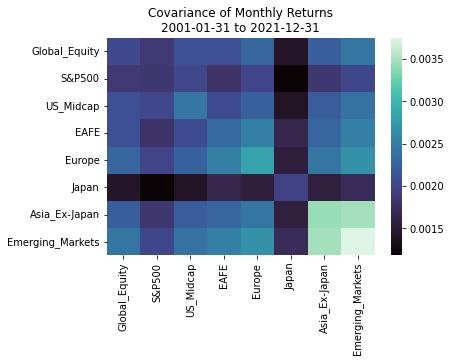

In [15]:
covHeatmap = sn.heatmap(sigma,cmap="mako")
covHeatmap.set(xticklabels=assets,yticklabels=assets)
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.title("Covariance of Monthly Returns\n"+startStr+" to " +endStr)
plt.show()

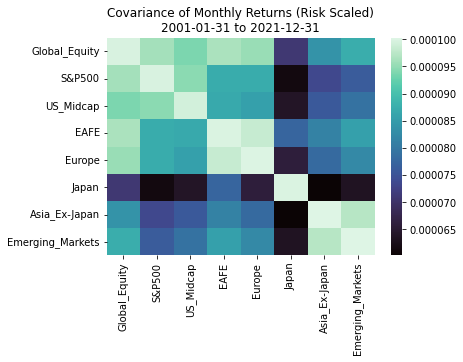

In [16]:
covHeatmapRisk = sn.heatmap(sigmaRisk,cmap="mako")
covHeatmapRisk.set(xticklabels=assets,yticklabels=assets)
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.title("Covariance of Monthly Returns (Risk Scaled)\n"+startStr+" to " +endStr)
plt.show()

Better to compare these values at similar scales. 

For the non risk-scaled data use `vmin=0,vmax=0.004` while for the risk-scaled data use `vmin=0,vmax=0.00011`.

To comapare all at the same scale, use `vmin=0,vmax=0.004`

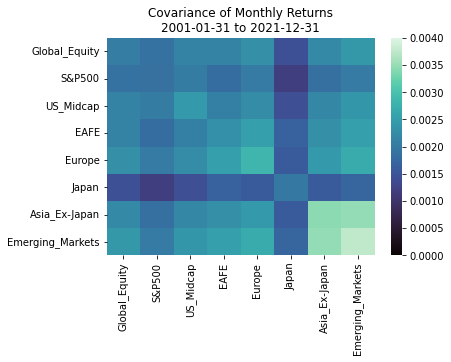

In [17]:
covHeatmap = sn.heatmap(sigma,cmap="mako",vmin=0,vmax=0.004)
covHeatmap.set(xticklabels=assets,yticklabels=assets)
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.title("Covariance of Monthly Returns\n"+startStr+" to " +endStr)
plt.show()

fig = covHeatmap.get_figure()
fig.savefig("figures/CovarianceMonthlyReturns-" + startStr + "-to-" + endStr + ".pdf",bbox_inches='tight')

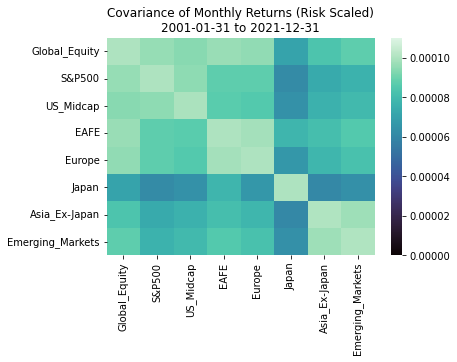

In [18]:
covHeatmapRisk = sn.heatmap(sigmaRisk,cmap="mako",vmin=0,vmax=0.00011)
covHeatmapRisk.set(xticklabels=assets,yticklabels=assets)
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.title("Covariance of Monthly Returns (Risk Scaled)\n"+startStr+" to " +endStr)
plt.show()

figRisk = covHeatmapRisk.get_figure()
figRisk.savefig("figures/CovarianceMonthlyReturnsRisk-" + startStr + "-to-" + endStr + ".pdf",bbox_inches='tight')

## QUBO Model Ising DOcplex

IBM's DOcplex is a native Python modeling library for optimization. You can read more and find examples in the documentation [here](http://ibmdecisionoptimization.github.io/docplex-doc/).

We will be using DOcplex to construct the quadratic program the specifications in the introduction, as it is compatible with pandas, numpy, and qiskit.

In [19]:
mdl = Model("Non-Scaled") # You can input a string into the argument if you want to name the model.

x = mdl.binary_var_list('x{}'.format(i) for i in range(numAssets)) # binary decision variables

# Objective Function to be maximized
objective = mdl.sum([mu[i]*x[i] for i in range(numAssets)])
objective -= q * mdl.sum([sigma[i,j]*x[i]*x[j] for i in range(numAssets) for j in range(numAssets)])

mdl.maximize(objective)
mdl.add_constraint(mdl.sum(x[i] for i in range(numAssets)) == B) # Adding the budget constraint

qp = from_docplex_mp(mdl) # Conversion to a quadratic program

In [20]:
qp

<QuadraticProgram: maximize -0.001021802031556314*x0^2 - 0.001875584261051034*..., 8 variables, 1 constraints, 'Non-Scaled'>

In [21]:
mdlRisk = Model("Risk-Scaled") # You can input a string into the argument if you want to name the model.

y = mdlRisk.binary_var_list('y{}'.format(i) for i in range(numAssets)) # binary decision variables

# Objective Function to be maximized
objectiveRisk = mdlRisk.sum([muRisk[i]*y[i] for i in range(numAssets)])
objectiveRisk -= q * mdlRisk.sum([sigmaRisk[i,j]*y[i]*y[j] for i in range(numAssets) for j in range(numAssets)])

mdlRisk.maximize(objectiveRisk)
mdlRisk.add_constraint(mdlRisk.sum(y[i] for i in range(numAssets)) == B) # Adding the budget constraint

qpRisk = from_docplex_mp(mdlRisk) # Conversion to a quadratic program

In [22]:
qpRisk

<QuadraticProgram: maximize -4.987133837665211e-05*y0^2 - 9.594932713590086e-0..., 8 variables, 1 constraints, 'Risk-Scaled'>

## Classical Solution

NOTE THAT THE DICT LABELS FOR PLOTTING ARE REVERSED FROM THE EIGENVECTOR LABELS

Now we can solve the quadratic program `qp` classically as a reference before we convert the quadratic program to a QUBO and solve using the quantum algorithms.

In [24]:
classicalResult = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qp)
# classicalResultEigenstate = (classicalResult.min_eigen_solver_result.eigenstate._primitive.data.real).tolist()
classicalResultEigenstate = classicalResult.min_eigen_solver_result.eigenstate.to_dict_fn().primitive
classicalResult

<MinimumEigenOptimizationResult: fval=0.012498444875498012, x0=1.0, x1=1.0, x2=1.0, x3=0.0, x4=0.0, x5=1.0, x6=1.0, x7=0.0, status=SUCCESS>

In [25]:
# making the labels for plotting
# labels = []
# for i in range(2**numAssets):
#     labels.append(format(i,'0'+str(numAssets)+'b'))
# fig = plot_histogram(dict(zip(labels, classicalResultEigenstate)),figsize=(60,10))
fig = plot_histogram(classicalResultEigenstate,figsize=(60,10))
fig.savefig("figures/ClassicalEigensolver-"+startStr+"-"+endStr+".pdf")
# fig

c:\Users\anish\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\visualization\counts_visualization.py:303: ComplexWarning: Casting complex values to real discards the imaginary part
  values = np.array(values, dtype=float)


In [26]:
classicalResultRisk = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qpRisk)
#classicalResultRiskEigenstate = (classicalResultRisk.min_eigen_solver_result.eigenstate._primitive.data.real).tolist()
classicalResultRiskEigenstate = classicalResultRisk.min_eigen_solver_result.eigenstate.to_dict_fn().primitive
classicalResultRisk


<MinimumEigenOptimizationResult: fval=0.00697634125569152, y0=1.0, y1=1.0, y2=1.0, y3=0.0, y4=0.0, y5=0.0, y6=1.0, y7=1.0, status=SUCCESS>

In [27]:
# making the labels for plotting
# labels = []
# for i in range(2**numAssets):
#     labels.append(format(i,'0'+str(numAssets)+'b'))
# fig = plot_histogram(dict(zip(labels, classicalResultRiskEigenstate)),figsize=(60,10))
fig = plot_histogram(classicalResultRiskEigenstate,figsize=(60,10))
fig.savefig("figures/ClassicalEigensolverRisk-"+startStr+"-"+endStr+".pdf")
# fig

c:\Users\anish\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\visualization\counts_visualization.py:303: ComplexWarning: Casting complex values to real discards the imaginary part
  values = np.array(values, dtype=float)


A clear result.

## Converting Quadratic Program into QUBO
Conversion to a QUBO is quite simple, and is necessary to be put into the qiskit functions for VQE and QAOA.

In [28]:
linearToPenalty = LinearEqualityToPenalty(penalty=penalty)
qubo = linearToPenalty.convert(qp)
quboRisk = linearToPenalty.convert(qpRisk)

In [29]:
qubo

<QuadraticProgram: maximize -8.001021802031556*x0^2 - 16.00187558426105*x0*x1 ..., 8 variables, 0 constraints, 'Non-Scaled'>

In [30]:
quboRisk

<QuadraticProgram: maximize -8.000049871338376*y0^2 - 16.000095949327136*y0*y1..., 8 variables, 0 constraints, 'Risk-Scaled'>

## Ansatz

The choice of the Ansatz, or variational wavefuction, is extremely important to the accuracy of the results. From the variational theory, the closer the wavefunction is to the ground state, the better result will be retrieved from the algorithm. Appropriate variational forms are an active area of research, and the choice becomes more difficult when the number of qubits and gates are limited. 

The one used in this work is touched upon in [this paper](https://arxiv.org/pdf/2106.07619.pdf). It takes a simple form, ie a series of rotation gates followed by entanglements between the qubits. This is then repeated in several layers. The number of repetitions is a choice of the user, but generally the more layers there are, the better the variational form will be. But as a reminder, there is a practical hardware limit that needs to be considered.

We'll now define and visualize this Ansatz.

In [31]:
reps = 2

ansatz = TwoLocal(num_qubits=numAssets, rotation_blocks='rx', entanglement_blocks= 'cz', reps=reps, entanglement='full')
ansatz.decompose().draw()

┌──────────┐                                                ┌──────────┐»
q_0: ┤ Rx(θ[0]) ├─■──■─────■─────■────────■────────■───────────■─┤ Rx(θ[8]) ├»
     ├──────────┤ │  │     │     │        │        │           │ └──────────┘»
q_1: ┤ Rx(θ[1]) ├─■──┼──■──┼──■──┼─────■──┼─────■──┼────────■──┼─────────────»
     ├──────────┤    │  │  │  │  │     │  │     │  │        │  │             »
q_2: ┤ Rx(θ[2]) ├────■──■──┼──┼──┼──■──┼──┼──■──┼──┼─────■──┼──┼─────────────»
     ├──────────┤          │  │  │  │  │  │  │  │  │     │  │  │             »
q_3: ┤ Rx(θ[3]) ├──────────■──■──┼──■──┼──┼──┼──┼──┼──■──┼──┼──┼──────■──────»
     ├──────────┤                │     │  │  │  │  │  │  │  │  │      │      »
q_4: ┤ Rx(θ[4]) ├────────────────■─────■──┼──■──┼──┼──■──┼──┼──┼──────┼──────»
     ├──────────┤                         │     │  │     │  │  │      │      »
q_5: ┤ Rx(θ[5]) ├─────────────────────────■─────■──┼─────■──┼──┼──────■──────»
     ├──────────┤                                  │        │  │             »
q_6: ┤ Rx(θ[6]) ├──────────────────────────────────■────────■──┼─────────────»
     ├──────────┤                                              │             »
q_7: ┤ Rx(θ[7]) ├──────────────────────────────────────────────■─────────────»
     └──────────┘                                                            »
«                                                                          »
«q_0: ───────────────────■──────────────────■───────────────■──────────────»
«           ┌──────────┐ │                  │               │              »
«q_1: ────■─┤ Rx(θ[9]) ├─■──────────────────┼───────■───────┼───────■──────»
«         │ └──────────┘      ┌───────────┐ │       │       │       │      »
«q_2: ─■──┼─────────────────■─┤ Rx(θ[10]) ├─■───────■───────┼───────┼──────»
«      │  │                 │ └───────────┘   ┌───────────┐ │       │      »
«q_3: ─┼──┼──────────────■──┼───────────────■─┤ Rx(θ[11]) ├─■───────■──────»
«      │  │              │  │               │ └───────────┘   ┌───────────┐»
«q_4: ─┼──┼──────■───────┼──┼───────■───────┼───────────────■─┤ Rx(θ[12]) ├»
«      │  │      │       │  │       │       │               │ └───────────┘»
«q_5: ─┼──┼──────■───────┼──┼───────┼───────┼───────■───────┼───────■──────»
«      │  │              │  │       │       │       │       │       │      »
«q_6: ─■──┼──────────────■──┼───────■───────┼───────■───────┼───────┼──────»
«         │                 │               │               │       │      »
«q_7: ────■─────────────────■───────────────■───────────────■───────■──────»
«                                                                          »
«                                                          ┌───────────┐      »
«q_0: ──────■───────────────────────■────────■───────────■─┤ Rx(θ[16]) ├──────»
«           │                       │        │           │ └───────────┘      »
«q_1: ──────┼────────────────────■──┼─────■──┼────────■──┼──────────────────■─»
«           │                    │  │     │  │        │  │                  │ »
«q_2: ──────┼────────────■───────┼──┼──■──┼──┼─────■──┼──┼───────────────■──┼─»
«           │            │       │  │  │  │  │     │  │  │               │  │ »
«q_3: ──────┼────────────■───────┼──┼──┼──┼──┼──■──┼──┼──┼───────■───────┼──┼─»
«           │                    │  │  │  │  │  │  │  │  │       │       │  │ »
«q_4: ──────■────────────────────■──┼──■──┼──┼──■──┼──┼──┼───────┼───────┼──┼─»
«     ┌───────────┐                 │     │  │     │  │  │       │       │  │ »
«q_5: ┤ Rx(θ[13]) ├─────────────────■─────■──┼─────■──┼──┼───────■───────┼──┼─»
«     └───────────┘┌───────────┐             │        │  │               │  │ »
«q_6: ──────■──────┤ Rx(θ[14]) ├─────────────■────────■──┼───────────────■──┼─»
«           │      ├───────────┤                         │                  │ »
«q_7: ──────■──────┤ Rx(θ[15]) ├─────────────────────────■──────────────────■─»
«                  └───────────┘                                         

## Classical Optimizer Choice
Both the VQE Algorithm and QAOA are hybrid algorithms, and thus care needs to be put into what classical optimizer is chosen. All of then availabile optimizers in qiskit may be found [here](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html). 

If you are going to be using a Quantum ASseMbly Language (QASM) simulator, then the qiskit-recommended optimizer is SPSA, which stands for Simultaneous Perturbation Stochastic Approximation. You can read more about it [here](https://www.jhuapl.edu/SPSA/). If you want quicker results, you can test out the COBYLA and the POWELL optimizers, or a number of others.

In [32]:
maxIter = 10000
# fidelity = QNSPSA.get_fidelity(ansatz) # only for QNSPSA
optimizer = SPSA(maxiter=500)  

# Classical optimizer – COBYLA(maxiter=maxIter), ADAM(maxiter=maxIter), NELDER_MEAD(maxiter=maxIter), 
# POWELL(maxiter=maxIter), SPSA(maxiter=100), QNSPSA(fidelity,maxiter=100)

## Variational Quantum Eigensolver

Now that we've set up the QUBO, we can go over the VQE algorithm in greater detail. 

### Variational Method

The goal of the Variational Method in quantum mechanics is to find the minimum eneregy (eigenvalue) of the Hamiltonian  (a matrix that captures the energetics of a system). We'll go over

For some Hamiltonian $H$ there exists some true ground state wavefunction $\left| \psi_0 \right\rangle$ such that

$$
\left\langle \psi_0 \right| H \left| \psi_0 \right\rangle = \left\langle \psi_0 \right| E_0 \left| \psi_0 \right\rangle = E_0 \left\langle \psi_0 \right| \left. \psi_0 \right\rangle = E_0
$$

where $E_0$ is the ground state energy, or minimum eigenvalue of $H$. 

However, there are cases where we want to calculate the minimum energy, but don't know the true ground state wavefunction. However, we know that because the lowest energy corresponds to only the ground state wavefunction, and that any other wavefunction will yield an expectation value with some higher energy, ie

$$
\left\langle \psi \right| H \left| \psi \right\rangle = \left\langle \psi \right| E \left| \psi \right\rangle = E \left\langle \psi \right| \left. \psi \right\rangle = E
\\
E > E_0
$$

Now, if the wavefunction is parametrized by some parameter(s) $\left\lbrace\theta_i\right\rbrace$, ie $\left| \psi \left( \theta \right) \right\rangle$, then an optimal set of variational parameters can be found that minimizes the energy as an approximation to the true ground state energy. That is,


$$
E = \left\langle \psi \left( \left\lbrace\theta_i\right\rbrace \right) \right| H \left| \psi \left( \left\lbrace\theta_i\right\rbrace \right) \right\rangle \geq E_0
$$


The VQE algorithm applies this method to allow a quantum computer prepare an Ansatz with some parameters, denoted by $\Psi \left\lbrace\theta_i\right\rbrace $, which is then the expectation value of the Hamiltonian that represents the problem. From here, the parameters are incrementally changed and optimized classically, and then re-input into the next iteration of the quantum circuit. This is then repeated until convergence and until the minimum energy and optimal parameters are found.

### Hamiltonian

It is worthwhile to see the form of the Hamiltonian that corresponds to the QUBO problem, and see what the qiskit functions will be doing.

In [33]:
def pauliDict(H):
    tempKey = [] 
    tempVal = [] 
    tempDict = {}
    for i in range(len(H)):
        tempDict[H.primitive.to_list()[i][0]] = H.primitive.to_list()[i][1]
    return tempDict

In [34]:
H, offset = qubo.to_ising()
pauliDict(H)

{'IIIIIIIZ': (7.999102285620301+0j),
 'IIIIIIZI': (8.000185504375825+0j),
 'IIIIIZII': (8.000402701273526+0j),
 'IIIIZIII': (7.998233555542274+0j),
 'IIIZIIII': (7.998048050756703+0j),
 'IIZIIIII': (7.998846265758079+0j),
 'IZIIIIII': (7.999592097197871+0j),
 'ZIIIIIII': (7.99930588469096+0j),
 'IIIIIIZZ': (4.000468896065263+0j),
 'IIIIIZIZ': (4.000525045220625+0j),
 'IIIIIZZI': (4.000505350089167+0j),
 'IIIIZIIZ': (4.000524850405837+0j),
 'IIIIZIZI': (4.00045329928524+0j),
 'IIIIZZII': (4.000516082733194+0j),
 'IIIZIIIZ': (4.000572980689544+0j),
 'IIIZIIZI': (4.000500502511857+0j),
 'IIIZIZII': (4.000561571626628+0j),
 'IIIZZIII': (4.000628448502814+0j),
 'IIZIIIIZ': (4.000357954598115+0j),
 'IIZIIIZI': (4.000295595228609+0j),
 'IIZIIZII': (4.000352205919496+0j),
 'IIZIZIII': (4.000414871777019+0j),
 'IIZZIIII': (4.000390829562385+0j),
 'IZIIIIIZ': (4.0005546408172075+0j),
 'IZIIIIZI': (4.000463805917757+0j),
 'IZIIIZII': (4.000549222659837+0j),
 'IZIIZIII': (4.000571834917947+0j),
 '

In [35]:
HRisk, offsetRisk = quboRisk.to_ising()
pauliDict(HRisk)

{'IIIIIIIZ': (8.000530928340686+0j),
 'IIIIIIZI': (8.00071996693891+0j),
 'IIIIIZII': (8.000765219981977+0j),
 'IIIIZIII': (8.000351397286332+0j),
 'IIIZIIII': (8.00033137468673+0j),
 'IIZIIIII': (8.000303088687861+0j),
 'IZIIIIII': (8.000598879884034+0j),
 'ZIIIIIII': (8.000576856368102+0j),
 'IIIIIIZZ': (4.000023987331784+0j),
 'IIIIIZIZ': (4.000023452159299+0j),
 'IIIIIZZI': (4.0000236545429395+0j),
 'IIIIZIIZ': (4.0000240992640945+0j),
 'IIIIZIZI': (4.000021816027003+0j),
 'IIIIZZII': (4.000021688365901+0j),
 'IIIZIIIZ': (4.000023826161504+0j),
 'IIIZIIZI': (4.0000218141843735+0j),
 'IIIZIZII': (4.000021370487415+0j),
 'IIIZZIII': (4.0000245907908445+0j),
 'IIZIIIIZ': (4.000017723329263+0j),
 'IIZIIIZI': (4.000015349652501+0j),
 'IIZIIZII': (4.000015968711661+0j),
 'IIZIZIII': (4.000019340371806+0j),
 'IIZZIIII': (4.000016496044117+0j),
 'IZIIIIIZ': (4.00002092678939+0j),
 'IZIIIIZI': (4.000018345454848+0j),
 'IZIIIZII': (4.000018966217036+0j),
 'IZIIZIII': (4.000020299923284+0j),


The Hamiltonian is the sum of the spin operators in the above dictionary, weighted by the corresponding coefficients. 

Note that this Hamiltonian takes the form of spin operators, which lends itself extremely well to quantum computers. In particular, spin operators can be directly hard-coded into quantum ciruits, and thus their expectation value can be measured.

### Qiskit Implementation of VQE

With the information above, one can build the circuits from scratch. However, one of the nice features of qiskit is that it has built in functions that can build them for us.

In [36]:
def getCountDictStateVecSim(vqeResult):
    tempState = []
    tempProb = []
    for sample in vqeResult.samples:
        tempProb.append(sample.probability)
        tempStr = ''
        for stateElement in reversed(sample.x):
            tempStr += str(int(stateElement))
        tempState.append(tempStr)
    return dict(zip(tempState, tempProb))

In [37]:
vqeInit = VQE(ansatz=ansatz,optimizer=optimizer, quantum_instance=backend)
vqe = MinimumEigenOptimizer(vqeInit)
vqeResult = vqe.solve(qubo)

if backend.name() == 'qasm_simulator':
    counts = vqeResult.min_eigen_solver_result.eigenstate
elif backend.name() == 'statevector_simulator':
    counts = getCountDictStateVecSim(vqeResult)
#endif

In [38]:
vqeResult

<MinimumEigenOptimizationResult: fval=0.012311348325738436, x0=0.0, x1=1.0, x2=1.0, x3=0.0, x4=0.0, x5=1.0, x6=1.0, x7=1.0, status=SUCCESS>

In [39]:
vqeFig = plot_histogram(counts,figsize=(60,10))
vqeFig.savefig("figures/VQE"+startStr+"-"+endStr+".pdf")

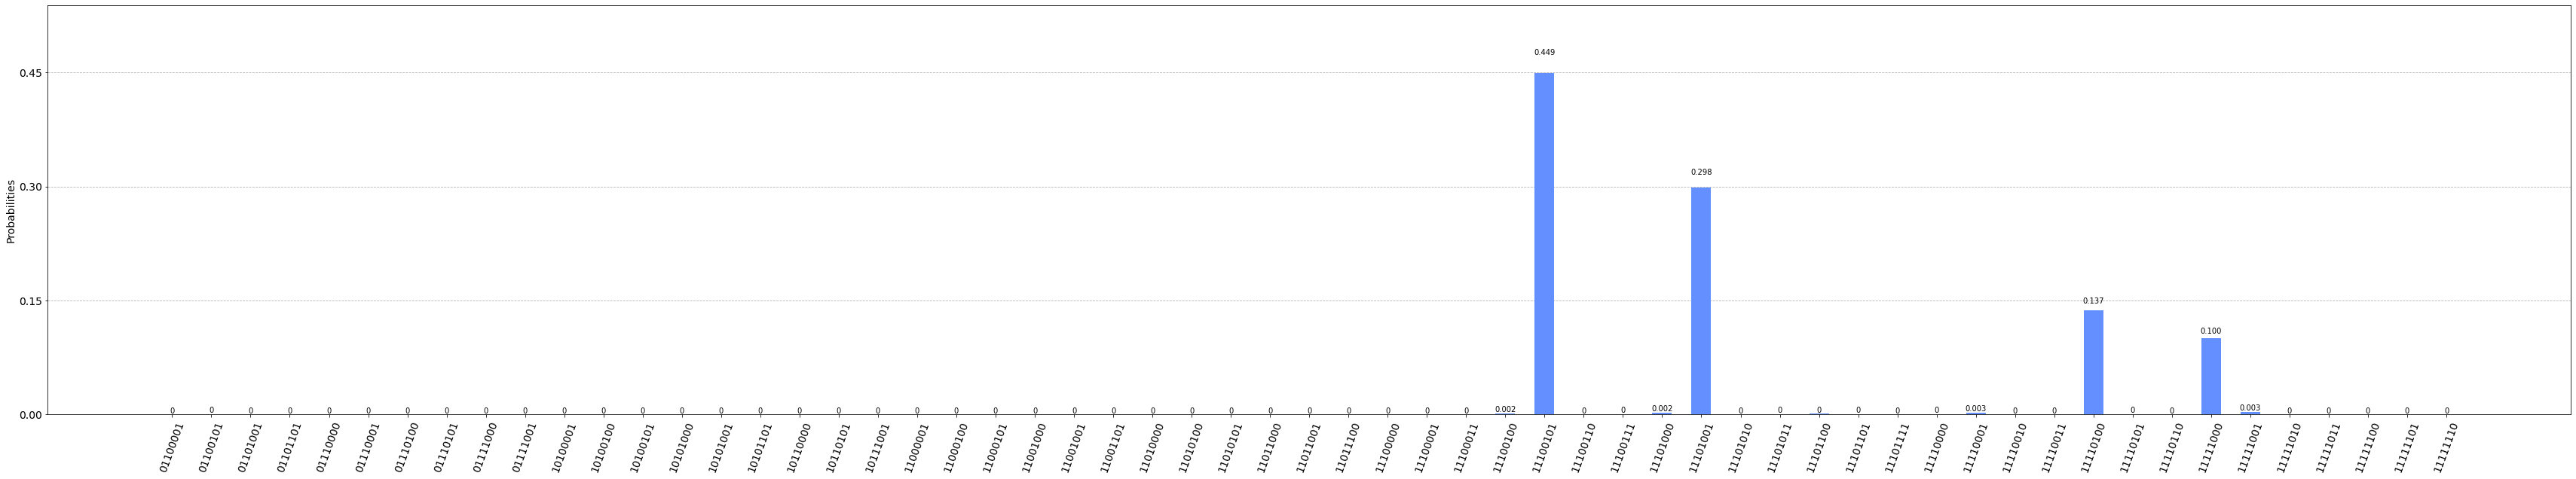

In [40]:
vqeFig

In [41]:
## ALTERNATIVE PLOT SCHEME

# samples_for_plot = {
#     " ".join(f"{vqeResult.variables[i].name}={int(v)}" for i, v in enumerate(sample.x)): sample.probability
#     for sample in vqeResult.samples
# }
# plot_histogram(samples_for_plot,figsize=(60,5))

In [42]:
vqeRiskInit = VQE(ansatz=ansatz,optimizer=optimizer, quantum_instance=backend)
vqeRisk = MinimumEigenOptimizer(vqeRiskInit)
vqeRiskResult = vqeRisk.solve(quboRisk)

if backend.name() == 'qasm_simulator':
    countsRisk = vqeRiskResult.min_eigen_solver_result.eigenstate
elif backend.name() == 'statevector_simulator':
    countsRisk = getCountDictStateVecSim(vqeRiskResult)
#endif

In [43]:
vqeRiskResult

<MinimumEigenOptimizationResult: fval=0.006976341255722218, y0=1.0, y1=1.0, y2=1.0, y3=0.0, y4=0.0, y5=0.0, y6=1.0, y7=1.0, status=SUCCESS>

In [44]:
vqeRiskFig = plot_histogram(countsRisk,figsize=(60,10))
vqeRiskFig.savefig("figures/VQERisk"+startStr+"-"+endStr+".pdf")

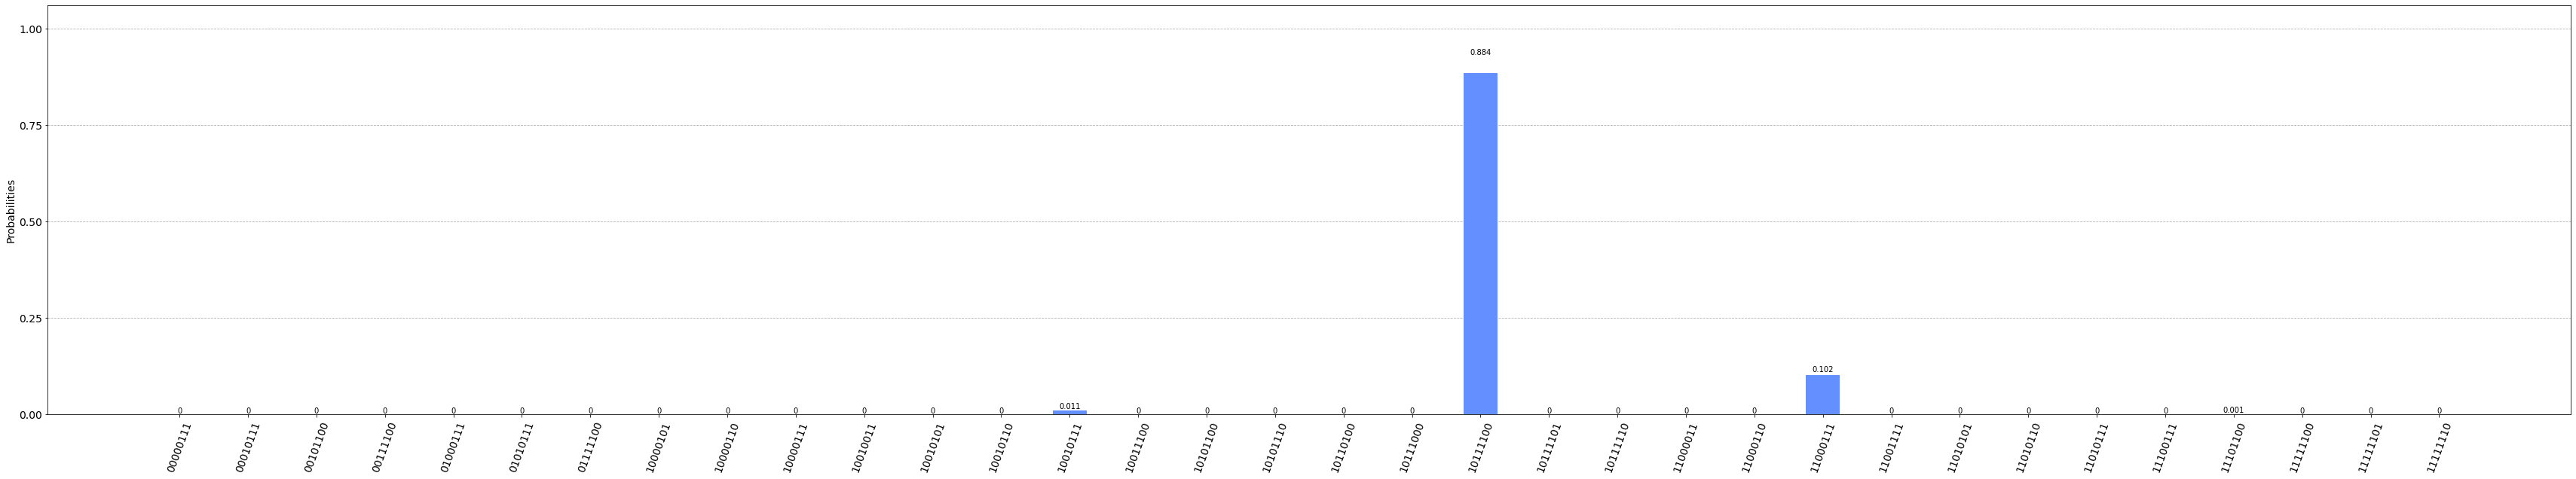

In [45]:
vqeRiskFig

Which matches the classical result.

## Quantum Approximation Optimization Algorithm


The Quantum Approximate Optimization Algorithm is similar to the VQE insofar that it is also a variational algorithm, and follows the same structure of using a classical optimizer to optimize the results from the quantum circuit, until the optimal eigenstate is obtained.

The form of the Ansatz is of note for this framework, and we will take care in examining it.

For more information, please read [this paper](https://arxiv.org/abs/1411.4028)


### Ansatz
Consider a unitary $U(\lbrace\beta_i\rbrace, \lbrace\gamma_i\rbrace)$ with some set of variational parameters $\lbrace\beta_i\rbrace, \lbrace\gamma_i\rbrace$, which is used to prepare a  state $\left| \psi(\lbrace\beta_i\rbrace, \lbrace\gamma_i\rbrace) \right\rangle$. 

The unitary operator $U(\lbrace\beta_i\rbrace, \lbrace\gamma_i\rbrace)$ is itself a combination of unitary operators 
$U(\lbrace\beta_i\rbrace) = e^{-i \lbrace\beta_i\rbrace H_m}$ and $U(\lbrace\gamma_i\rbrace) = e^{-i \lbrace\gamma_i\rbrace H_c}$, where $H_m$ is the mixing Hamiltonian and $H_c$ is the cost Hamiltonian.

The cost Hamiltonian is such that its ground state encodes the solution to the optimization problem.

The state is prepared by applying these unitaries as alternating blocks of the two unitaries applied $p$ times such that 

$$
\left| \psi(\lbrace\beta\rbrace, \lbrace\gamma\rbrace) \right\rangle = U(\beta_1) U(\gamma_1) \cdots U(\beta_p) U(\gamma_p) 
\left| 0\right\rangle
$$


### Qiskit Implementation of QAOA

In [46]:
qaoaInit = QAOA(optimizer=optimizer, reps=reps, quantum_instance=backend)
qaoa = MinimumEigenOptimizer(qaoaInit)
qaoaResult = qaoa.solve(qubo)

if backend.name() == 'qasm_simulator':
    counts = qaoaResult.min_eigen_solver_result.eigenstate
elif backend.name() == 'statevector_simulator':
    counts = getCountDictStateVecSim(qaoaResult)
#endif

In [47]:
qaoaResult

<MinimumEigenOptimizationResult: fval=0.0124984448754617, x0=1.0, x1=1.0, x2=1.0, x3=0.0, x4=0.0, x5=1.0, x6=1.0, x7=0.0, status=SUCCESS>

In [48]:
qaoaFig = plot_histogram(counts,figsize=(60,10))
qaoaFig.savefig("figures/QAOA-"+startStr+"-"+endStr+".pdf")

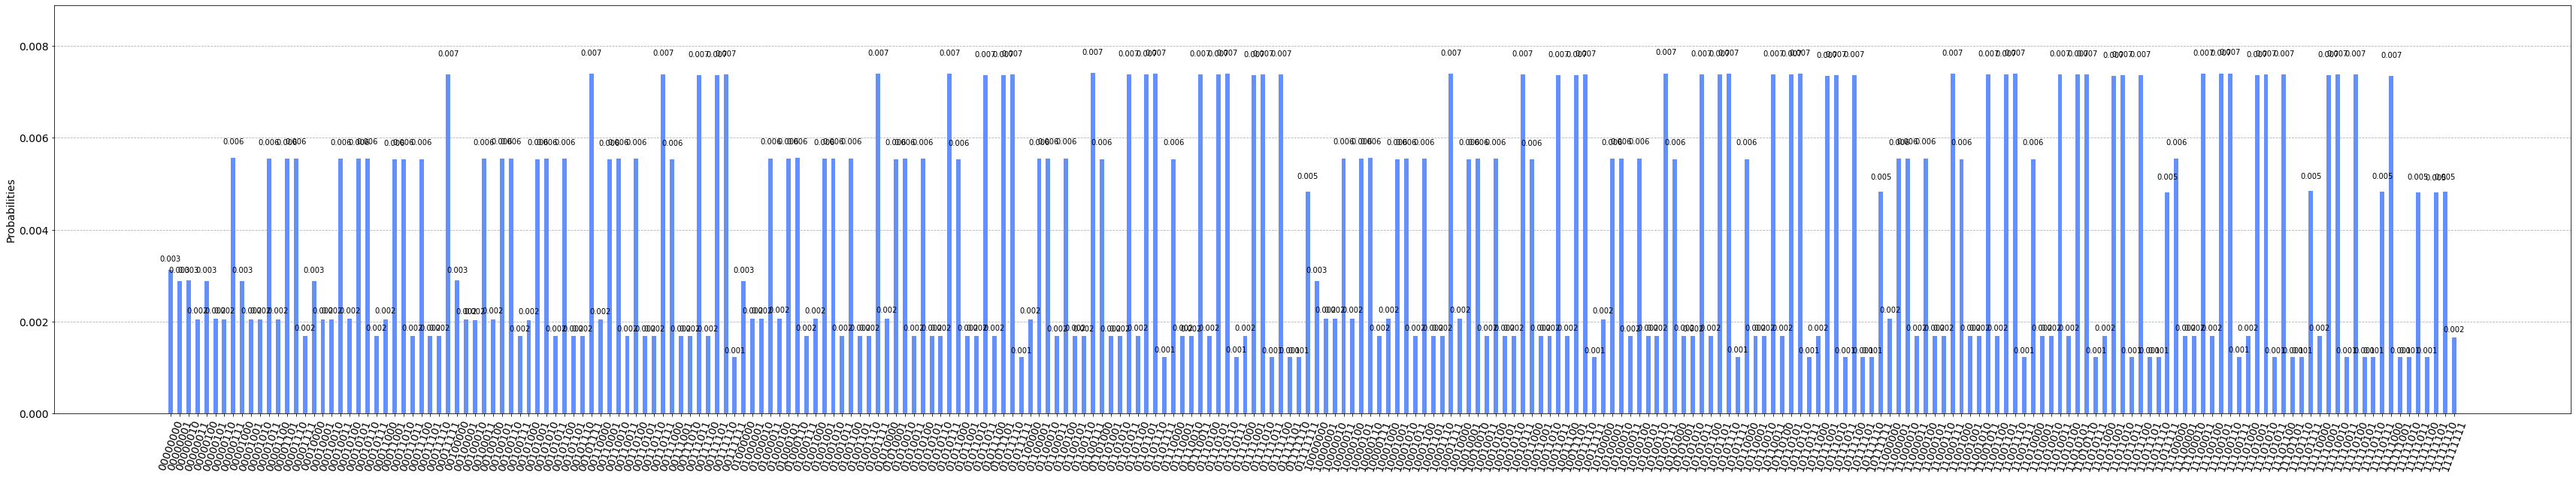

In [49]:
qaoaFig

In [57]:
qaoaRiskInit = QAOA(optimizer=optimizer, reps=reps, quantum_instance=backend)
qaoaRisk = MinimumEigenOptimizer(qaoaRiskInit)
qaoaRiskResult = qaoaRisk.solve(quboRisk)

if backend.name() == 'qasm_simulator':
    countsRisk = qaoaRiskResult.min_eigen_solver_result.eigenstate
elif backend.name() == 'statevector_simulator':
    countsRisk = getCountDictStateVecSim(qaoaRiskResult)
#endif

In [58]:
qaoaRiskResult

<MinimumEigenOptimizationResult: fval=0.006976341255722218, y0=1.0, y1=1.0, y2=1.0, y3=0.0, y4=0.0, y5=0.0, y6=1.0, y7=1.0, status=SUCCESS>

In [59]:
qaoaRiskFig = plot_histogram(countsRisk,figsize=(60,10))
qaoaRiskFig.savefig("figures/QAOARisk-"+startStr+"-"+endStr+".pdf")

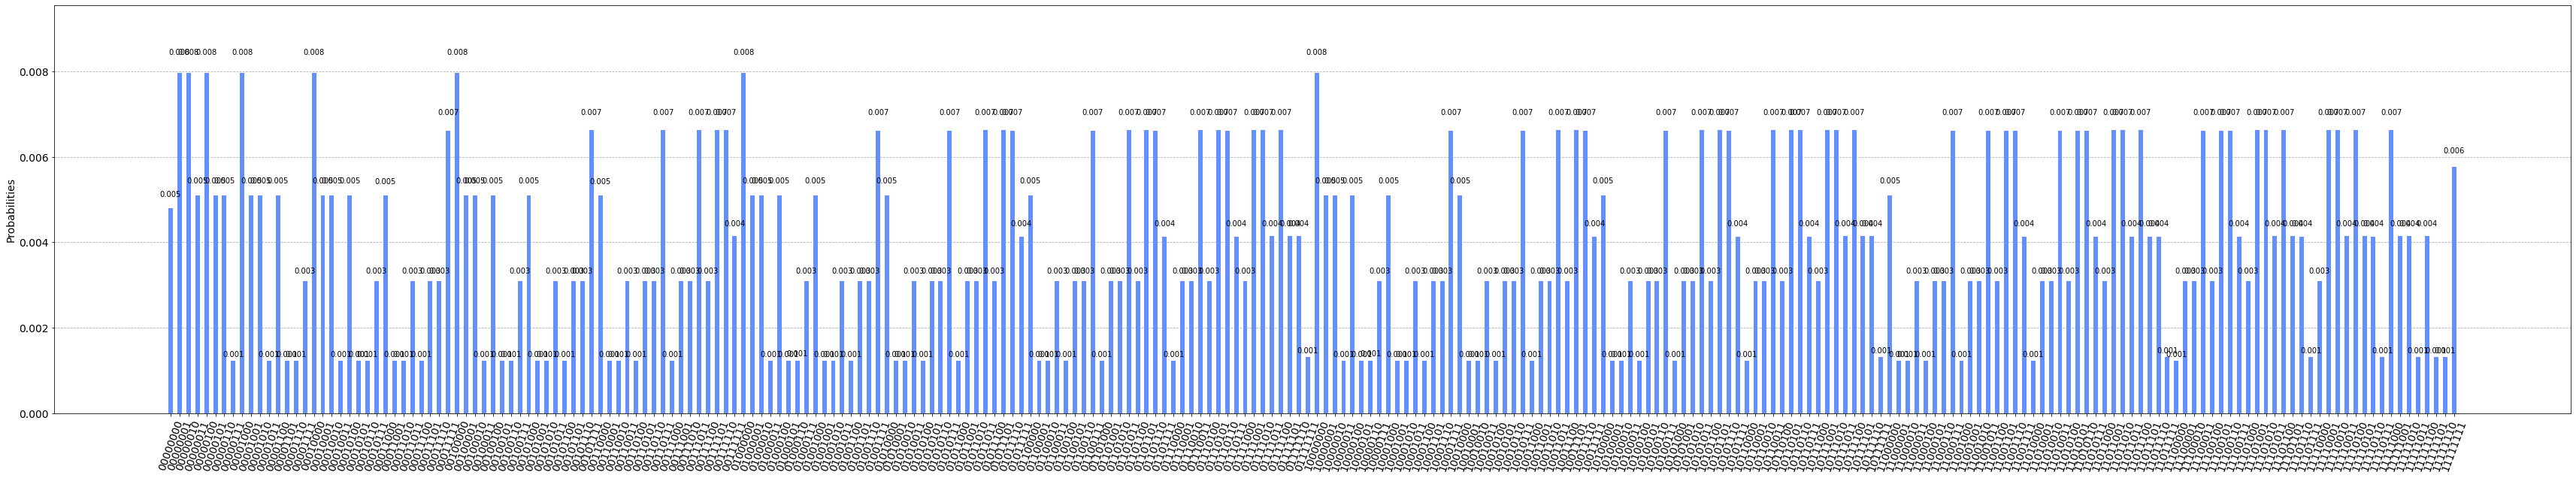

In [60]:
qaoaRiskFig

Which matches the VQE result and the classical result. However, you'll note here that the probabilities are less well-defined. I invite you to play around with the ansatz to see if you can improve the result by increasing the number of repetitions. 

However, with real hardware, an issue that arises is the number of operations (gates) you can actually apply. So there's often a balance that needs to be found between the number of layers and the capacity of the hardware.

In [61]:
classicalResult

<MinimumEigenOptimizationResult: fval=0.012498444875498012, x0=1.0, x1=1.0, x2=1.0, x3=0.0, x4=0.0, x5=1.0, x6=1.0, x7=0.0, status=SUCCESS>

In [62]:
vqeResult

<MinimumEigenOptimizationResult: fval=0.012311348325738436, x0=0.0, x1=1.0, x2=1.0, x3=0.0, x4=0.0, x5=1.0, x6=1.0, x7=1.0, status=SUCCESS>

In [63]:
qaoaResult

<MinimumEigenOptimizationResult: fval=0.0124984448754617, x0=1.0, x1=1.0, x2=1.0, x3=0.0, x4=0.0, x5=1.0, x6=1.0, x7=0.0, status=SUCCESS>

In [64]:
classicalResultRisk

<MinimumEigenOptimizationResult: fval=0.00697634125569152, y0=1.0, y1=1.0, y2=1.0, y3=0.0, y4=0.0, y5=0.0, y6=1.0, y7=1.0, status=SUCCESS>

In [65]:
vqeRiskResult

<MinimumEigenOptimizationResult: fval=0.006976341255722218, y0=1.0, y1=1.0, y2=1.0, y3=0.0, y4=0.0, y5=0.0, y6=1.0, y7=1.0, status=SUCCESS>

In [66]:
qaoaRiskResult

<MinimumEigenOptimizationResult: fval=0.006976341255722218, y0=1.0, y1=1.0, y2=1.0, y3=0.0, y4=0.0, y5=0.0, y6=1.0, y7=1.0, status=SUCCESS>

# Exploratory Data Visualization

It's good to plot the results to see what we get, before we begin applying some weights based on other ideas.

In [67]:
def getCombinations(inputVal):
    combinations = []
    if type(inputVal) == str:
        for perm in set(permutations(inputVal)):
            combinations.append(''.join(perm))
        #endFor
    elif type(inputVal) == list:
        for i in range(len(inputVal)):
            inputVal[i] = int(inputVal[i])
        #endFor
        for perm in set(permutations(inputVal)):
            combinations.append(list(perm))
        #endFor
    else:
        print("Input a string or list of ones and zeroes")
    return combinations

def countNonZeroElemInList(inputList):
    numNonZeroElem = 0.
    for x in inputList:
        if x != 0:
            numNonZeroElem += 1
        else:
            numNonZeroElem += 0
        #endIf
    #endFor
    return numNonZeroElem

def assetTotalPortfolioGrowth(initialPortfolioValue,selectedAssets,testDF):
    amountSplit = initialPortfolioValue/countNonZeroElemInList(selectedAssets)
    assetGrowth = []
    for i in range(len(selectedAssets)):
        if selectedAssets[i] == 1:
            tempDF = testDF.iloc[:,i]
            amountTemp = amountSplit
            for pctChg in tempDF:
                amountTemp += pctChg*amountTemp
            assetGrowth.append(amountTemp)
        else:
            assetGrowth.append(0.)
        #endIf
    #endFor
    return assetGrowth

def assetGrowthTimeSeries(initialPortfolioValue,selectedAssets,testDF):
    amountSplit = initialPortfolioValue/countNonZeroElemInList(selectedAssets)
    assetGrowthTS = []
    for i in range(len(selectedAssets)):
        if selectedAssets[i] == 1:
            tempVec = []
            tempDF = testDF.iloc[:,i]
            amountTemp = amountSplit
            for pctChg in tempDF:
                amountTemp += pctChg*amountTemp
                tempVec.append(amountTemp)
            assetGrowthTS.append(tempVec)
        else:
            tempVec = []
            tempDF = testDF.iloc[:,i]
            for pctChg in tempDF:
                tempVec.append(0.0)
            assetGrowthTS.append(tempVec)
        #endIf
    #endFor
    return assetGrowthTS

def assetGrowthTimeSeriesWeighted(initialPortfolioValue,selectedAssets,testDF,weights):
    assetGrowthTS = []
    for i in range(len(selectedAssets)):
        if selectedAssets[i] == 1:
            tempVec = []
            tempDF = testDF.iloc[:,i]
            amountTemp = initialPortfolioValue*weights[i]
            for pctChg in tempDF:
                amountTemp += pctChg*amountTemp
                tempVec.append(amountTemp)
            assetGrowthTS.append(tempVec)
        else:
            tempVec = []
            tempDF = testDF.iloc[:,i]
            for pctChg in tempDF:
                tempVec.append(0.0)
            assetGrowthTS.append(tempVec)
        #endIf
    #endFor
    return assetGrowthTS


def portfolioGrowthTimeSeries(portfolioTS):
    portfolioValueTS = []
    for i in range(len(portfolioTS[0])):
        tempVal = 0.0
        for j in range(len(portfolioTS)):
            tempVal += portfolioTS[j][i]
        portfolioValueTS.append(tempVal)
    return portfolioValueTS

In [68]:
assetTest = qaoaRiskResult.x.tolist() 
amountInit = 1000 

In [69]:
allAssetCombinations = getCombinations(assetTest)

In [70]:
dateList = dfMonthlyReturns.index

In [71]:
# # Gives total number of chosen assets, AKA budget. More of a sanity check.
# numAssetsChosen = countNonZeroElemInList(assetTest)

# # Gives each selected asset's total final value in a list
# finalAssetValues = assetTotalPortfolioGrowth(amountInit,assetTest,dfMonthlyReturns)

# # Gives the time series of each portfolio element as a list of lists. In each list, 
# # the final element is the final value of the held asset.
# chosenAssetsTimeSeries = assetGrowthTimeSeries(amountInit,assetTest,dfMonthlyReturns)

# # Gives the time series for the total portfolio value. The final element is the final portfolio value.
# portfolioTimeSeries = portfolioGrowthTimeSeries(chosenAssetsTimeSeries)

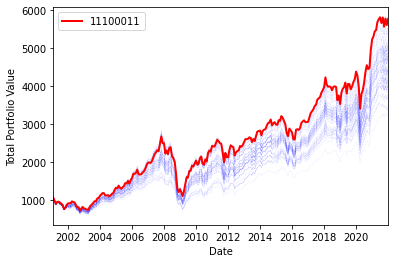

In [72]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
for i in range(len(allAssetCombinations)):
    chosenAssetsTimeSeries = assetGrowthTimeSeries(amountInit,allAssetCombinations[i],dfMonthlyReturns)
    portfolioTimeSeries = portfolioGrowthTimeSeries(chosenAssetsTimeSeries)
    label = ''
    for element in allAssetCombinations[i]:
        label+=str(element)
    #endFor
    ax.plot(dateList,portfolioTimeSeries,color='blue',linestyle='--',alpha=0.1,linewidth=0.5)
#endFor

winningAssetCombination = assetTest
winningAssetTimeSeries = assetGrowthTimeSeries(amountInit,winningAssetCombination,dfMonthlyReturns)
winningPortfolioTimeSeries = portfolioGrowthTimeSeries(winningAssetTimeSeries)

label = ''
for element in winningAssetCombination:
    label+=str(element)
#endFor
ax.plot(dateList,winningPortfolioTimeSeries,label=label,color='red',alpha=1,linewidth=2)

plt.xlim(startDate,endDate)
plt.ylabel('Total Portfolio Value')
plt.xlabel('Date')
plt.legend()#bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

fig.savefig('figures/portfolio-'+label+'risk-'+str(q)+'-'+startStr+"-"+endStr+'.pdf',bbox_inches='tight')

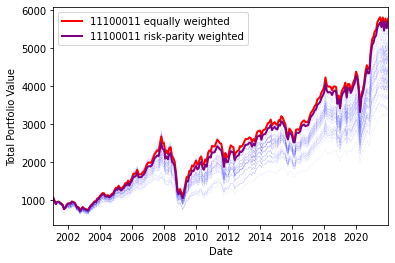

In [73]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
for i in range(len(allAssetCombinations)):
    chosenAssetsTimeSeries = assetGrowthTimeSeries(amountInit,allAssetCombinations[i],dfMonthlyReturns)
    portfolioTimeSeries = portfolioGrowthTimeSeries(chosenAssetsTimeSeries)
    label = ''
    for element in allAssetCombinations[i]:
        label+=str(element)
    #endFor
    ax.plot(dateList,portfolioTimeSeries,color='blue',linestyle='--',alpha=0.1,linewidth=0.5)
#endFor

winningAssetCombination = assetTest
winningAssetTimeSeries = assetGrowthTimeSeries(amountInit,winningAssetCombination,dfMonthlyReturns)
winningPortfolioTimeSeries = portfolioGrowthTimeSeries(winningAssetTimeSeries)

label = ''
for element in winningAssetCombination:
    label+=str(element)
#endFor

label += ' equally weighted'
ax.plot(dateList,winningPortfolioTimeSeries,label=label,color='red',alpha=1,linewidth=2)

portfolioWeights = [0.223214286,0.233800935,0.2042007,0.0,0.0,0.0,0.172583826,0.165250236]
weightedWinningAssetTimeSeries = assetGrowthTimeSeriesWeighted(amountInit,assetTest,dfMonthlyReturns,portfolioWeights)
weightedWinningPortfolioTimeSeries = portfolioGrowthTimeSeries(weightedWinningAssetTimeSeries)

label = ''
for element in winningAssetCombination:
    label+=str(element)
#endFor

label += ' risk-parity weighted'

ax.plot(dateList,weightedWinningPortfolioTimeSeries,label=label,color='purple',alpha=1,linewidth=2)

plt.xlim(startDate,endDate)
plt.ylabel('Total Portfolio Value')
plt.xlabel('Date')
plt.legend()#bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

fig.savefig('figures/weighted-comparison-portfolio-'+label+'risk-'+str(q)+'-'+startStr+"-"+endStr+'.pdf',bbox_inches='tight')

In [74]:
from qiskit import QuantumCircuit, assemble, Aer
from math import pi, sqrt
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_bloch_vector
sim = Aer.get_backend('aer_simulator')

In [75]:
qc = QuantumCircuit(1)

qc.draw()

q:

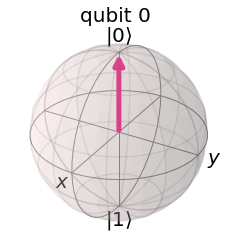

In [76]:
qc.save_statevector()
qobj = assemble(qc)
state = sim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

In [77]:
qc = QuantumCircuit(1)
qc.draw()
qc.save_statevector()
qobj = assemble(qc)
state = sim.run(qobj).result().get_statevector()
fig=plot_bloch_multivector(state)
fig.savefig('figures/bloch-no-rotate.pdf', bbox_inches='tight')

In [78]:
qc = QuantumCircuit(1)
qc.rx(theta=pi/2,qubit=0)
qc.draw()
qc.save_statevector()
qobj = assemble(qc)
state = sim.run(qobj).result().get_statevector()
fig=plot_bloch_multivector(state)
fig.savefig('figures/bloch-pi-over-two-x-rotate.pdf', bbox_inches='tight')